# Explainable model for 1DCNN

## Resource Availability

In [2]:
# This all packages are necessary for running followong code
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense,Dropout
from matplotlib import pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import tensorflow as tf
import os
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Conv1D,Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from keras.wrappers.scikit_learn import KerasClassifier
from Functions.supervised_functions import df_to_x_y
from numpy import concatenate
import sys

                     frequency     RoCoF  Actual Total Load  Biomass  \
Datetime                                                               
2016-01-01 00:15:00  49.998040  0.000009            50731.0   4908.0   
2016-01-01 00:30:00  50.005657  0.000016            50476.0   4916.0   
2016-01-01 00:45:00  50.004560 -0.000026            50205.0   4916.0   
2016-01-01 01:00:00  49.979307  0.000014            49901.0   4903.0   
2016-01-01 01:15:00  50.005025  0.000020            49285.0   4890.0   
...                        ...       ...                ...      ...   
2016-01-31 23:00:00  50.010564 -0.000016            58878.0   4959.0   
2016-01-31 23:15:00  50.030442  0.000051            57635.0   4956.0   
2016-01-31 23:30:00  50.014870 -0.000034            56684.0   4951.0   
2016-01-31 23:45:00  50.034898  0.000023            55637.0   4950.0   
2016-02-01 00:00:00  50.042786  0.000000            54715.0   4952.0   

                     Fossil Brown coal/Lignite  Fossil Coal-der

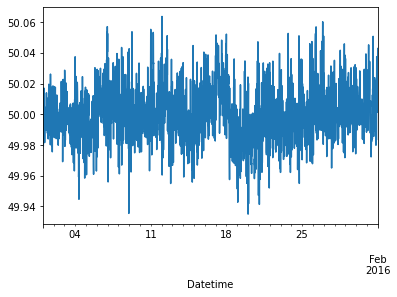

In [3]:
#-------------------------------------------------------------------
#please change appropriate path here for loading dataset into dataframe
df2=pd.read_hdf('/Users/abhishekpanchal/Desktop/15_min_data/1month_freq&features.h5')

df2=df2.iloc[:,:]
df2['frequency'].plot()
#For cleaning process
df2=df2.dropna()
#For renaming column names in dataset
df2=df2.rename(columns={"Actual Total Load [MW] - BZN|DE-AT-LU":"Actual Total Load","Biomass  - Actual Aggregated [MW]":"Biomass","Fossil Brown coal/Lignite  - Actual Aggregated [MW]":"Fossil Brown coal/Lignite","Fossil Coal-derived gas  - Actual Aggregated [MW]":"Fossil Coal-derived gas","Fossil Gas  - Actual Aggregated [MW]":"Fossil Gas","Fossil Hard coal  - Actual Aggregated [MW]":"Fossil Hard coal","Fossil Oil  - Actual Aggregated [MW]":"Fossil Oil","Geothermal  - Actual Aggregated [MW]":"Geothermal","Hydro Pumped Storage  - Actual Aggregated [MW]":"Hydro Pumped Storage","Hydro Pumped Storage  - Actual Consumption [MW]":"Hydro Pumped Storage Consumption","Hydro Run-of-river and poundage  - Actual Aggregated [MW]":"Hydro Run-of-river and poundage","Hydro Water Reservoir  - Actual Aggregated [MW]":"Hydro Water Reservoir","Nuclear  - Actual Aggregated [MW]":"Nuclear","Other  - Actual Aggregated [MW]":"Other","Other renewable  - Actual Aggregated [MW]":"Other renewable","Solar  - Actual Aggregated [MW]":"Solar","Waste  - Actual Aggregated [MW]":"Waste","Wind Offshore  - Actual Aggregated [MW]":"Wind Offshore","Wind Onshore  - Actual Aggregated [MW]":"Wind Onshore"})
print(df2)
print(df2.columns)

## Data Preprocessing

In [4]:
#-------------------------------------------------------------------
#For scaling values within 0 and 1
scaler=MinMaxScaler(feature_range=(0, 1))
scaler=scaler.fit(df2)
df=scaler.transform(df2)


In [5]:
#-------------------------------------------------------------------
#for changing window size
window_size=8
# Conversion of dataframe into X and Y
X,Y =df_to_x_y(df,window_size)
X.shape,Y.shape

((2968, 8, 21), (2968,))

In [6]:
#-------------------------------------------------------------------
#For splitting dataset into training and test datasets
X_train,Y_train =X[0:2226],Y[0:2226]
#X_val,Y_val=X[1484:2226],Y[1484:2226]
X_test,Y_test=X[2226:],Y[2226:]

## Machine learning algorithm selection

In [7]:
#-------------------------------------------------------------------
#Building 1DCNN model
import shap
shap.initjs()
model=Sequential()
model.add(Conv1D(filters=512,kernel_size=3,input_shape=(window_size,21),activation='relu'))
model.add(Conv1D(filters=256,kernel_size=3,activation='relu'))
model.add(Dense(128,activation='relu'))

model.add(Flatten())
model.add(Dense(1))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 6, 512)            32768     
                                                                 
 conv1d_1 (Conv1D)           (None, 4, 256)            393472    
                                                                 
 dense (Dense)               (None, 4, 128)            32896     
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 459,649
Trainable params: 459,649
Non-trainable params: 0
_________________________________________________________________


In [8]:
#-------------------------------------------------------------------
# To mark check point where we get low validation loss during model training  
cp=ModelCheckpoint('model/',save_best_only=True)
model.compile(loss=MeanSquaredError(),optimizer=Adam(learning_rate=0.001))


In [9]:
#-------------------------------------------------------------------
#fitting the model
history=model.fit(X_train,Y_train,batch_size=32,validation_split=0.1,epochs=20,callbacks=[cp],verbose=1) 

Epoch 1/20
59/63 [===========================>..] - ETA: 0s - loss: 0.0237

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


63/63 [==============================] - 2s 26ms/step - loss: 0.0230 - val_loss: 0.0112
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 0.0111 - val_loss: 0.0126
Epoch 3/20
58/63 [==========================>...] - ETA: 0s - loss: 0.0115

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


63/63 [==============================] - 1s 20ms/step - loss: 0.0114 - val_loss: 0.0100
Epoch 4/20
59/63 [===========================>..] - ETA: 0s - loss: 0.0093

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


63/63 [==============================] - 1s 22ms/step - loss: 0.0095 - val_loss: 0.0095
Epoch 5/20
57/63 [==========================>...] - ETA: 0s - loss: 0.0087

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


63/63 [==============================] - 1s 22ms/step - loss: 0.0087 - val_loss: 0.0075
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 0.0081 - val_loss: 0.0079
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 0.0080 - val_loss: 0.0081
Epoch 8/20
63/63 [==============================] - 0s 6ms/step - loss: 0.0076 - val_loss: 0.0110
Epoch 9/20
63/63 [==============================] - 0s 6ms/step - loss: 0.0080 - val_loss: 0.0084
Epoch 10/20
62/63 [============================>.] - ETA: 0s - loss: 0.0086

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


63/63 [==============================] - 1s 24ms/step - loss: 0.0085 - val_loss: 0.0075
Epoch 11/20
59/63 [===========================>..] - ETA: 0s - loss: 0.0076

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


63/63 [==============================] - 1s 20ms/step - loss: 0.0076 - val_loss: 0.0073
Epoch 12/20
63/63 [==============================] - 0s 6ms/step - loss: 0.0077 - val_loss: 0.0081
Epoch 13/20
57/63 [==========================>...] - ETA: 0s - loss: 0.0078

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


63/63 [==============================] - 1s 20ms/step - loss: 0.0077 - val_loss: 0.0072
Epoch 14/20
63/63 [==============================] - 0s 7ms/step - loss: 0.0073 - val_loss: 0.0082
Epoch 15/20
63/63 [==============================] - 0s 7ms/step - loss: 0.0076 - val_loss: 0.0075
Epoch 16/20
63/63 [==============================] - 0s 6ms/step - loss: 0.0076 - val_loss: 0.0073
Epoch 17/20
63/63 [==============================] - 0s 6ms/step - loss: 0.0069 - val_loss: 0.0072
Epoch 18/20
63/63 [==============================] - 0s 6ms/step - loss: 0.0068 - val_loss: 0.0083
Epoch 19/20
63/63 [==============================] - 0s 6ms/step - loss: 0.0067 - val_loss: 0.0076
Epoch 20/20
63/63 [==============================] - 0s 6ms/step - loss: 0.0074 - val_loss: 0.0098


In [10]:
#-------------------------------------------------------------------
#For loading model
from tensorflow.keras.models import load_model
model=load_model('model/')

## Performance on training data

In [11]:
#-------------------------------------------------------------------
#Predictions on training dataset 
train_predictions=model.predict(X_train)


70/70 [==============================] - 0s 2ms/step


In [12]:
#-------------------------------------------------------------------
#inverse transform of training data
inv_train = concatenate((train_predictions, X_train[:,0,1:]), axis=1)
inv_train = scaler.inverse_transform(inv_train)
inv_train = inv_train[:,0]
inv_train
Y_train = Y_train.reshape((len(Y_train)), 1)
inv_y_train = concatenate((Y_train, X_train[:,0,1:]), axis=1)
inv_y_train= scaler.inverse_transform(inv_y_train)
inv_y_train = inv_y_train[:,0]
#Create data frame for comparing train actuls and train predictions 
train_results=pd.DataFrame(data={'Train Predictions':inv_train,'Actuals':inv_y_train})
train_results

,Train Predictions,Actuals
0,50.012072,50.017048
1,50.012018,50.005149
2,50.011237,50.010352
3,49.991314,49.993461
4,50.009110,50.003336
...,...,...
2221,49.998344,50.001379
2222,50.003769,50.000705
2223,49.995346,49.996622
2224,50.003152,49.989067


R2 score Performance: 0.6019727904810824
MSE_train: 0.0001123614332312455
MAE_train: 0.008215382124245536


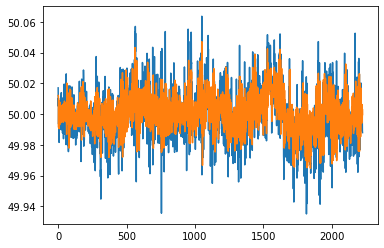

In [13]:
#-------------------------------------------------------------------
#creating plot for train actuals vs train predictions

plt.plot(inv_y_train)
plt.plot(inv_train)
#for calculating R2 score on training dataset
r2=r2_score(inv_y_train,inv_train)
print('R2 score Performance:',r2)
#for calculating MSE on training dataset
mse_train=mean_squared_error(inv_y_train,inv_train)
print('MSE_train:',mse_train)
#for calculating MAE on training dataset
mae_train=mean_absolute_error(inv_y_train,inv_train)
print('MAE_train:',mae_train)


## Performance on test data

In [14]:
#-------------------------------------------------------------------
#for test dataset
test_predictions=model.predict(X_test)


24/24 [==============================] - 0s 3ms/step


In [15]:
#-------------------------------------------------------------------
#For inverse transform of test dataset

inv_test = concatenate((test_predictions, X_test[:,0,1:]), axis=1)
inv_test = scaler.inverse_transform(inv_test)

inv_test = inv_test[:,0]
inv_test
Y_test = Y_test.reshape((len(Y_test)), 1)
inv_y_test = concatenate((Y_test, X_test[:,0,1:]), axis=1)
inv_y_test= scaler.inverse_transform(inv_y_test)
inv_y_test = inv_y_test[:,0]
# create data frame for comparison of test actual values and test prediction values 
test_results=pd.DataFrame(data={'Test Predictions':inv_test,'Actuals':inv_y_test})
test_results

,Test Predictions,Actuals
0,49.999896,49.977875
1,49.994141,49.992806
2,49.997533,49.996989
3,50.000016,49.988127
4,49.988082,49.992370
...,...,...
737,49.991596,50.010564
738,50.011212,50.030442
739,50.012106,50.014870
740,50.018079,50.034898


R2 score Performance: 0.3714734160776759
MSE_test: 0.00014674847775581889
MAE_test: 0.009298426689221989


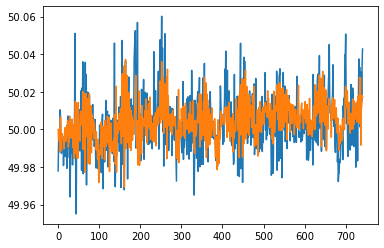

In [16]:
#-------------------------------------------------------------------
#creating plot for test actuals vs test predictions

plt.plot(inv_y_test)
plt.plot(inv_test)
#for calculating R2 score of test dataset
r2_test=r2_score(inv_y_test,inv_test)
print('R2 score Performance:',r2_test)
#for calculating MSE on test dataset
mse_test=mean_squared_error(inv_y_test,inv_test)
print('MSE_test:',mse_test)
#for calculating MAE on test dataset
mae_test=mean_absolute_error(inv_y_test,inv_test)
print('MAE_test:',mae_test)

## Loss curve

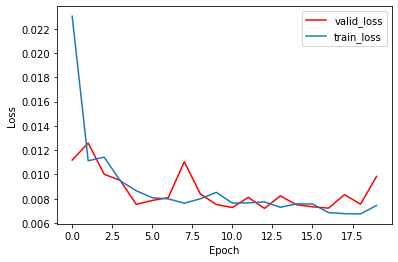

In [17]:
#-------------------------------------------------------------------
#for plotting loss curve of validation loss and training loss
plt.plot(history.history['val_loss'],color='red')
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['valid_loss','train_loss'])

## Calculation of SHAP values

In [18]:
#-------------------------------------------------------------------
#Generating SHAP values for 1DCNN model
import shap
shap.initjs()

background = X_train[:100,:,:]
explainer=shap.DeepExplainer(model,background)
print(explainer)

shap_values =explainer.shap_values(X_test)

shap_values=np.array(shap_values)
shap_values=shap_values[0,:,:,:]

print(shap_values)


keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


[[[-8.50587515e-04 -2.46992837e-05  1.54233490e-04 ... -9.05635837e-04
    3.16665241e-03  3.13495914e-03]
  [ 5.38190789e-03 -2.04626345e-03  2.16232788e-04 ... -1.75083512e-04
    6.64342345e-03  5.72234191e-03]
  [ 2.27174481e-04 -9.92973106e-04  1.09876423e-03 ...  5.96871526e-04
    1.66228824e-02  5.98558037e-03]
  ...
  [-7.87124568e-04  1.64138945e-05 -7.40381593e-04 ...  7.91147750e-04
   -1.00073925e-02 -1.01327898e-02]
  [-1.57194877e-02 -3.67935977e-03  2.69356253e-06 ... -4.36985404e-03
    6.04548534e-03 -1.36269300e-03]
  [-7.84470820e-03 -1.86046642e-02  3.41332189e-04 ...  5.75006402e-03
   -9.98605658e-03 -1.83369961e-03]]

 [[-3.79218246e-03  6.90180982e-04  1.54549252e-04 ... -8.57693040e-04
    2.88542596e-03  2.94009655e-03]
  [ 2.21666663e-03 -6.68680991e-04  5.13665452e-04 ... -6.39939007e-05
    6.22487521e-03  5.54592159e-03]
  [-3.75894288e-04 -1.02629132e-03  8.73003066e-04 ...  4.83754534e-04
    1.56662109e-02  5.62558617e-03]
  ...
  [-2.62131079e-03 -9.1

## Summary Plot 

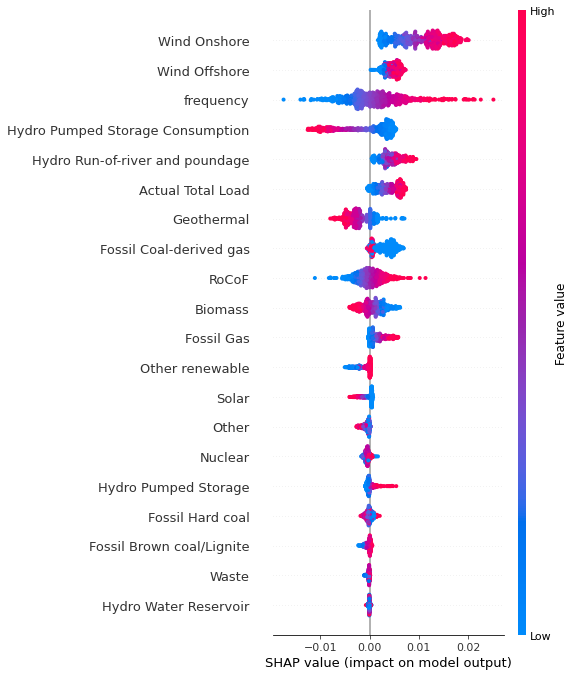

In [19]:
#-------------------------------------------------------------------
#For creating summary plot 
features=['frequency','RoCoF','Actual Total Load','Biomass','Fossil Brown coal/Lignite','Fossil Coal-derived gas','Fossil Gas','Fossil Hard coal','Fossil Oil','Geothermal','Hydro Pumped Storage','Hydro Pumped Storage Consumption','Hydro Run-of-river and poundage','Hydro Water Reservoir','Nuclear','Other','Other renewable','Solar','Waste','Wind Offshore','Wind Onshore']
shap.summary_plot(shap_values[:,0,:],X_test[:,0,:],feature_names=features)

## Feature Importance plot

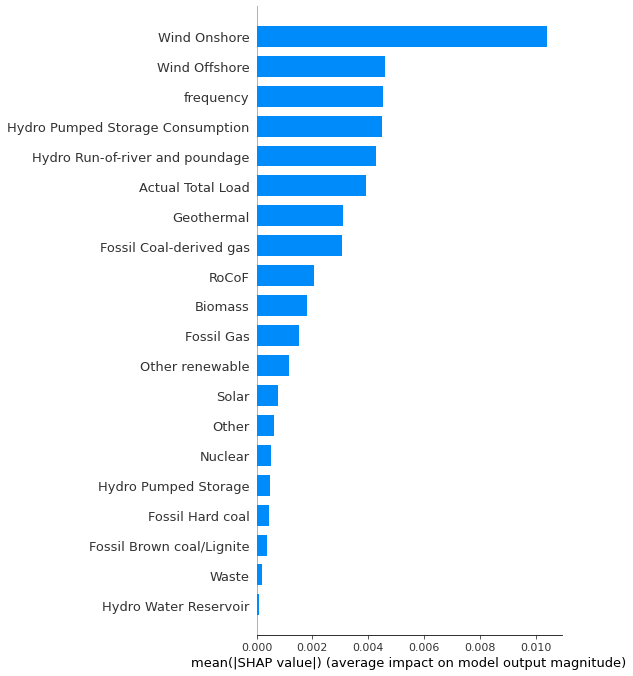

In [20]:
#-------------------------------------------------------------------
#For creating Feature Importance plot
shap.summary_plot(shap_values[:,0,:],X_test[:,0,:],feature_names=features,plot_type="bar")

## Force plot

In [21]:
#-------------------------------------------------------------------
#For creating Force Plot 
shap.initjs()
expected_val=np.array(explainer.expected_value)
shap.force_plot(expected_val,shap_values[200,1],X_test[200,1],feature_names=features)

## Decision plot

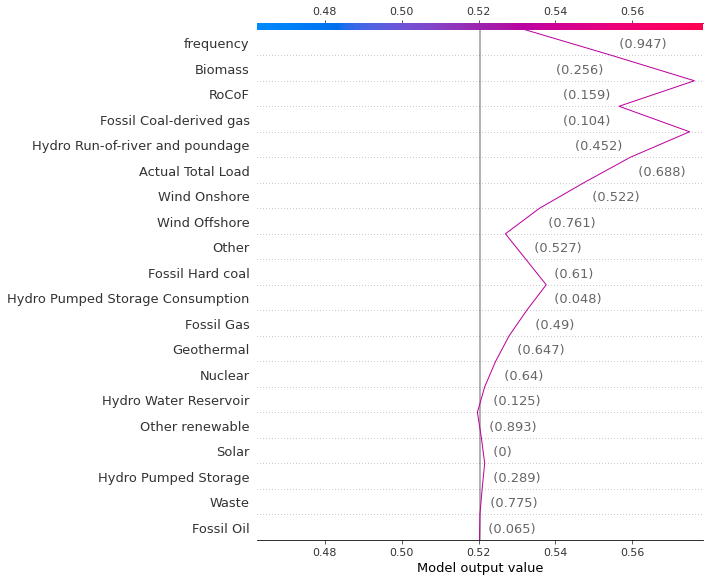

In [22]:
#-------------------------------------------------------------------
#For creating decision plot 
shap.decision_plot(expected_val, shap_values[200,1],X_test[200,1],feature_names = features)